# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

## Getting Started

In this project, we will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. We will know the dataset loaded successfully if the size of the dataset is reported.

In [2]:
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
from sklearn.cross_validation import cross_val_score 
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from scipy import stats
from pandas import DataFrame, Series
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import mixture
%matplotlib inline

try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Dataset could not be loaded. Is the dataset missing?


## Data Exploration
In this section, we will begin exploring the data through visualizations and code to understand how each feature is related to the others. We will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which we will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [25]:
# Display a description of the dataset
display(data.describe())
print ('Median for Fresh', np.median(data['Fresh']))
print np.mean(data['Fresh'])
print ('Median for Milk',np.median(data['Milk']))
print ('Median for Grocery',np.median(data['Grocery']))
print ('Median for Frozen',np.median(data['Frozen']))
print ('Median for Detergents_Paper',np.median(data['Detergents_Paper']))
print ('Median for Delicatessen',np.median(data['Delicatessen']))

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


('Median for Fresh', 8504.0)
12000.2977273
('Median for Milk', 3627.0)
('Median for Grocery', 4755.5)
('Median for Frozen', 1526.0)
('Median for Detergents_Paper', 816.5)
('Median for Delicatessen', 965.5)


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [26]:
#Select three indices of your choice you wish to sample from the dataset
indices = [50, 301, 401]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,6269,1095,1980,3860,609,2162
1,5283,13316,20399,1809,8752,172
2,27167,2801,2128,13223,92,1902


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:** 
**The sample with indice 50** has a lower cost of Fresh, Milk, Grocery and Detergents_Paper than mean values. Frozen cost is at the average and Delicatessen is above the mean value. Their overall cost is low, which would make me think that this would be a rather small grocery store maybe close to the city center or this could be a restaurant whose cost would much lower than a market.

**The sample with indice 301** has Fresh, Frozen and Delicatessen cost below the mean. And Milk, Grocery and Detergents_Paper costs are very high. This could be convenience store or supermarket.

**The sample with indice 401** has very high cost in Fresh, Frozen, very low cost in Detergents_Paper, Milk, Grocery and an average cost in Delicatessen. This could be a chain of some type of restaurant or grocery store.



### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.



In [27]:
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop('Detergents_Paper', axis = 1)

# Split the data into training and testing sets using the given feature as the target
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Detergents_Paper'], 
                                                    test_size=0.25, random_state=0)

# Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
#score = cross_val_score(regressor, X_test, y_test, cv=10) #, scoring='r2'
#print ('r2 score from cross_val: ', score)
s = regressor.score(X_test, y_test)
print ('regressor.score: ', s)
y_pred = regressor.predict (X_test)
r2 = r2_score(y_test, y_pred)
print ('r2_score: ', r2)

('regressor.score: ', 0.72865518125414541)
('r2_score: ', 0.72865518125414541)


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature relevant for identifying a specific customer?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:** The Decision Tree Regressor has been applied to the data with the removed column one by one for all the columns. The R^2  score results for all the removed columns are as follows. 

When Fresh column is removed, R^2 score is -0.252 

When Milk column is removed, R^2 score is 0.365 	
When Grocery column is removed, R^2 score is 0.602	 
When Frozen column is removed, R^2 score is 0.253	 
When Detergents_Paper is removed, R^2 score is 0.728	
When Delicatessen is removed, R^2 score is -11

The model has failed to predict Fresh and Delicatessen columns as the results of those columns has negative R^2 values. Grocery and Detergents_Paper columns can be considered relatively well predicted. Milk and Frozen columns are predicted but with a low R^2 value 0.365 and 0.253 respectively. So I expect Grocery and Detergents_Paper columns may not be relevant to understand customer purchase Fresh and Delicatessen columns can be relevant. Milk and Frozen columns may be slightly relevant with the features have positive R^2 values and also for understanding customer purchase.

I also expect to see correlation between the features with high R^2 values, and I do not expect any correlation for Fresh and Delicatessen feature between them and other features. 


### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

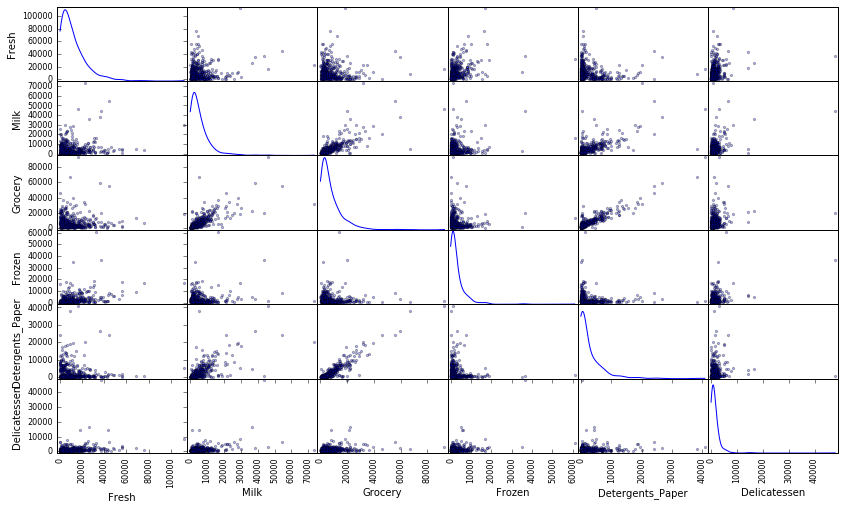

In [28]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:** As suspected before, there are correlations between the features that has high R^2 values such as Grocery and Detergents_Paper features. The above visualization also shows that Milk also have small correlation with Grocery and Detergents_Paper. I am now suspicious about the Delicatessen feature. It seems to have some correlations with the other features. To make sure and have a better understanding we need to scale all the data, since it is clear from diagonal graphics that the datas aren’t distributed normally or symmetricly. We can  understand that by comparing mean and median values of each features. The medain values for each feature are as follows: 8504 for Fresh, 3627 for Milk, 4755 for Grocery, 1526 for Frozen, 816 for Detergents_Paper and 965 for Delicatessen. All of the median values are less than the mean values of those features as they can be seen in Table 1. When the median is less than mean value, the data can be called skewed right. The median gets closer to first quartile. It is obvious that most of the datas are skewed right and the gaps between mean and median are large.

## Data Preprocessing
In this section, we will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results we obtain from our analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.


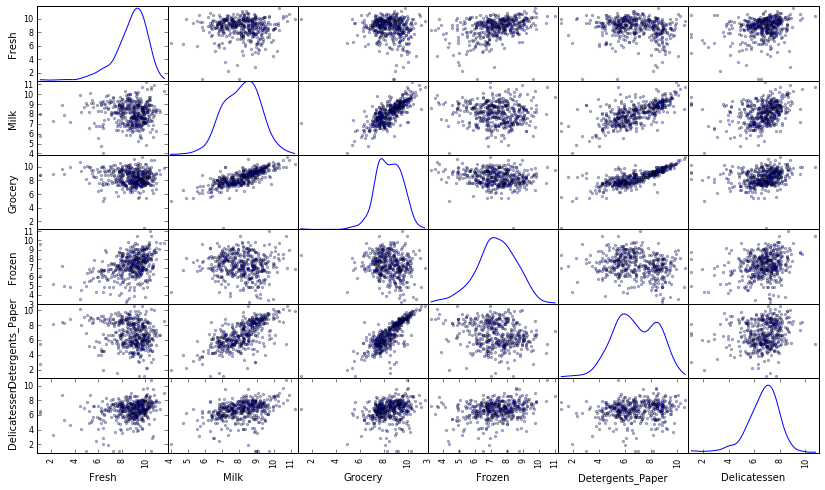

In [29]:
# Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

It can be seen in above visualization that the correlation between Grocery, Detergents_Paper and Milk features are obvious, especially the correlations between Milk is stronger now. And Delicatessen has no correlation between the other features as I suspected. 

The mean and median values are much closer or almost same. Data distribution is more symmetric now. The values can be seen in below calculation.


In [30]:
# Display the log-transformed sample data
display(log_samples)
print log_data.keys()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,8.743372,6.998510,7.590852,8.258422,6.411818,7.678789
1,8.572249,9.496722,9.923241,7.500529,9.077038,5.147494
2,10.209758,7.937732,7.662938,9.489713,4.521789,7.550661


Index([u'Fresh', u'Milk', u'Grocery', u'Frozen', u'Detergents_Paper',
       u'Delicatessen'],
      dtype='object')


In [31]:
display(log_data.describe())
print ('Median for Fresh', np.median(log_data['Fresh']))
print ('Mean for Fresh',np.mean(log_data['Fresh']))
print ('Median for Milk',np.median(log_data['Milk']))
print ('Mean for Milk',np.mean(log_data['Milk']))
print ('Median for Grocery',np.median(log_data['Grocery']))
print ('Mean for Grocery',np.mean(log_data['Grocery']))
print ('Median for Frozen',np.median(log_data['Frozen']))
print ('Mean for Frozen',np.mean(log_data['Frozen']))
print ('Median for Detergents_Paper',np.median(log_data['Detergents_Paper']))
print ('Mean for Detergents_Paper',np.mean(log_data['Detergents_Paper']))
print ('Median for Delicatessen',np.median(log_data['Delicatessen']))
print ('Mean for Delicatessen',np.mean(log_data['Delicatessen']))

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,8.730544,8.121047,8.441169,7.301396,6.785972,6.665133
std,1.480071,1.081365,1.116172,1.284540,1.721020,1.310832
min,1.098612,4.007333,1.098612,3.218876,1.098612,1.098612
25%,8.048059,7.334981,7.674616,6.609678,5.548101,6.011875
50%,9.048286,8.196159,8.467057,7.330388,6.705018,6.872645
75%,9.737064,8.880480,9.273854,8.175896,8.274341,7.506728
max,11.627601,11.205013,11.437986,11.016479,10.617099,10.777768


('Median for Fresh', 9.0482861053926182)
('Mean for Fresh', 8.7305440411981667)
('Median for Milk', 8.1961592768879665)
('Mean for Milk', 8.1210470671206902)
('Median for Grocery', 8.4670570721762104)
('Mean for Grocery', 8.4411687715756312)
('Median for Frozen', 7.3303878196849146)
('Mean for Frozen', 7.3013957369160707)
('Median for Detergents_Paper', 6.7050177249030547)
('Mean for Detergents_Paper', 6.7859720213520891)
('Median for Delicatessen', 6.8726448950319199)
('Mean for Delicatessen', 6.6651330520140206)


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.


In [32]:
# For each feature find the data points with extreme high or low values
index = []
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25) #, axis=0
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3-Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    outlier = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    index.append(outlier.index)
    print outlier.index
    display(outlier)
  
# Select the indices for data points you wish to remove
outliers = [65, 66, 75, 128, 154]

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':
Int64Index([65, 66, 81, 95, 96, 128, 171, 193, 218, 304, 305, 338, 353, 355,
            357, 412],
           dtype='int64')


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':
Int64Index([86, 98, 154, 356], dtype='int64')


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':
Int64Index([75, 154], dtype='int64')


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':
Int64Index([38, 57, 65, 145, 175, 264, 325, 420, 429, 439], dtype='int64')


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':
Int64Index([75, 161], dtype='int64')


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':
Int64Index([66, 109, 128, 137, 142, 154, 183, 184, 187, 203, 233, 285, 289,
            343],
           dtype='int64')


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


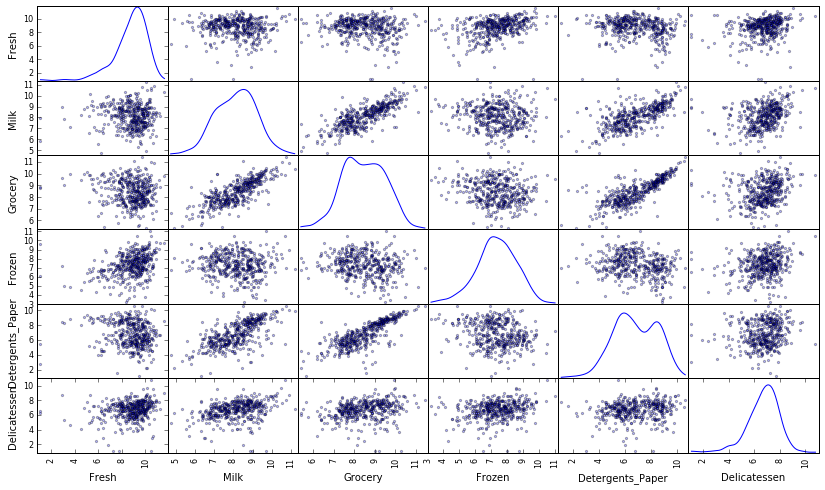

In [33]:
pd.scatter_matrix(good_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 4
*Are there any data points considered outliers for more than one feature? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:** Now we can consider to remove outliers as a part of preprocessing the features. Detecting outliers in the data is extremely important because presence of the outliers can often skew the results of cluster and component analysis. Some clustering methods are sensitive to outliers such as K-Means, so for more reliable results, we should look for the outliers. There are many rules detecting them. Here we will use Tukey’s Method. Tukey’s Method starts with finding 1st and 3rd Quartiles (Q1, Q3). Interquartile Range (IQR) can be obtained by substracting Q1 from Q3. When we substract IQR from Q1 and add it to Q3, we can obtain a range which already put many data out of the range and too many data could be outside the range. We can have larger range by multiplying IQR with a constant 1.5 or for even larger range just for the extreme outliers, the constant can be set to 3.0 or any other number.  Choosing the constant, deciding which data could be outside of the model is a very critical job. It effects the results. And one can end up with a data point in a different cluster. Which means one customer could be in the wrong group and be treated wrong. For the customer dataset, when I set the constant 1.5, 42 datas are detected as outliers for all features. Some of the outliers were same for some features. Considering the total number of data points which is 440, 42 data could be too much, almost 10% of the data. I only will choose points as outliers which belong more than one feature. So 5 points are chosen for outliers.

## Feature Transformation
In this section we will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. 


[ 0.44302505  0.26379218  0.1230638   0.10120908  0.04850196  0.02040793]
[[-0.16746374  0.40143866  0.43811142 -0.17820975  0.75142613  0.14987105]
 [ 0.68593522  0.16722783  0.07072902  0.50054207  0.04244398  0.49414702]
 [-0.67738927  0.04020501 -0.01953317  0.31504299 -0.21170161  0.62855082]
 [-0.204293    0.01281068  0.05567564  0.78544905  0.20961368 -0.54233972]
 [ 0.00261356 -0.71923846 -0.3553861   0.0330861   0.55815441  0.20918629]
 [-0.02915623  0.54018269 -0.82053348 -0.02054106  0.18238824 -0.01974794]]


,0,1,2,3,4,5
0,-0.167464,0.401439,0.438111,-0.178210,0.751426,0.149871
1,0.685935,0.167228,0.070729,0.500542,0.042444,0.494147
2,-0.677389,0.040205,-0.019533,0.315043,-0.211702,0.628551
3,-0.204293,0.012811,0.055676,0.785449,0.209614,-0.542340
4,0.002614,-0.719238,-0.355386,0.033086,0.558154,0.209186
5,-0.029156,0.540183,-0.820533,-0.020541,0.182388,-0.019748


          0
0  0.443025
1  0.706817
2  0.829881
3  0.931090
4  0.979592
5  1.000000


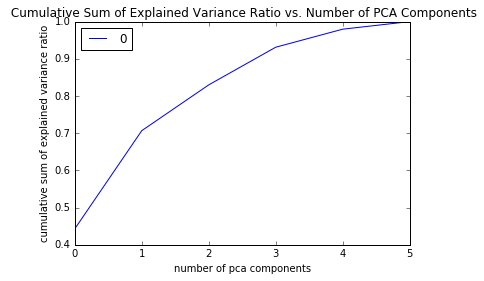

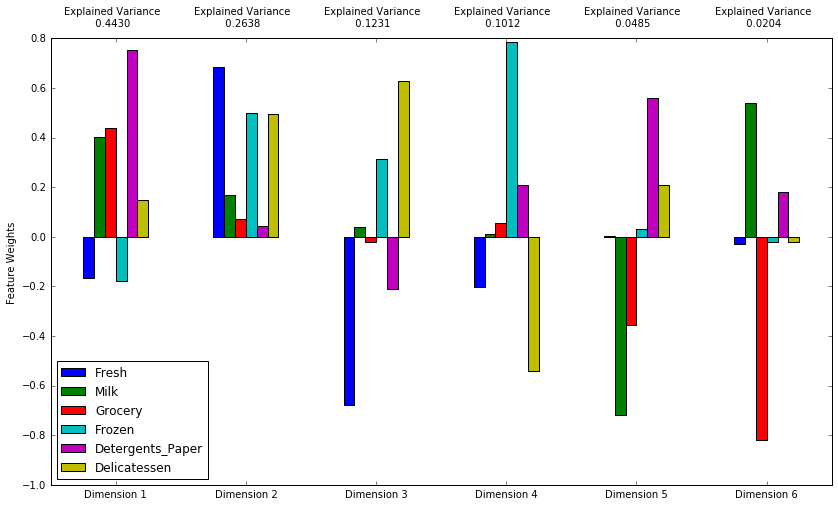

In [34]:
# Apply PCA to the good data with the same number of dimensions as features
n = len(good_data.columns)
pca = PCA(n_components = n)
pca.fit(good_data)
print pca.explained_variance_ratio_
print pca.components_
pca_components_df = DataFrame(pca.components_)
display (pca_components_df)
evr = np.cumsum(pca.explained_variance_ratio_)
evr_df = DataFrame(evr)
print evr_df
evr_df.plot()
plt.xlabel('number of pca components')
plt.ylabel('cumulative sum of explained variance ratio')
plt.title(' Cumulative Sum of Explained Variance Ratio vs. Number of PCA Components')

# Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:**
At the top of the graphic, explained variance ratio can be seen for all of the components (dimensions). The cumulative sum of explained variance ratio can also be seen in Figure 5. The variance of all of the 6 components starting from the first component are 0.44, 0.26, 0.12, 0.10, 0.04, 0.02. There is serious variance ratio drop can be observed after the third component (Figure 5). The total explained variances are for  all dimensions are, starting from the first one, 0.44, 0.70, 0.82, 0.93, 0.97 and 1. We can see that after the third dimension the total variance doesn’t change too much. The total variance difference between 2 and 4 dimensions (0.70 and 0.93) is 0.23.

The level of correlation can be seen that by looking at the magnitude of constants of every feature in every components and either they are positive or negative. If the feature weights are large, then those features are strongly correlated, or if the magnitude is small, the features have small correlation or if they are negative, the features are not correlated with the features which has a positive value. The first dimension best represents in terms of customer spending is Detergents_Paper, Grocery and Milk. In the first dimension, if one of the feature increase, the others are expected to increase too. The second dimension represents Fresh, Frozen and Delicatessen. The third dimension represents the correlation between decreasing Fresh and increasing Frozen and Delicatessen. The fourth dimension represents the correlation between increasing Frozen, Detergents_Paper and decreasing Delicatessen.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [35]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-1.1404,0.6710,0.9823,0.0603,1.1423,-0.0055
1,2.6714,-0.3807,-1.2410,1.5933,-0.5509,-0.0132
2,-2.6362,2.3118,0.7328,0.4172,-0.5960,0.0324


### Observation
**The sample with indice 50** has negative D1 value. Since D1 represents Detergents_Paper, Grocery and Milk, we can say that this customer has lower cost for these products. Because of D2 which is 0.67, this customer may have higher cost (but not too much) for Fresh, Frozen and Delicatessen. D3 is 0.98 which also tells the customer tend to buy Delicatessen rather than Fresh and D4 is 0.06 which may show the tendency of buying products of Frozen. 

**The sample with indice 301** has high positive value of D1 and  negative D2. So this customer spends more for Detergents_Paper, Grocery, Milk than Fresh, Frozen and Delicatessen. Positive D3 and D4 values indicate that when this customer spend some money for Fresh, Frozen, Delicatessen group, they prefer Fresh and Frozen over Delicatessen.

**The sample with indice 401** has same directions with the customer indice 50, but higher in the magnitude which means this customer has similar tendencies with the that customer but buys a larger amount of Fresh, Frozen and Delicatessen, buys less amount of Detergents_Paper, Grocery and Milk. Because of D3 and D4 values, Delicatessen and Frozen spending is relatively higher than Fresh.



**These observations are parallel to the observations done at the beginning.**

### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, we will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [36]:
# Fit PCA to the good data using only two dimensions
pca = PCA(2)
pca.fit(good_data)

# Apply a PCA transformation the good data
reduced_data = pca.transform(good_data)

# Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [37]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-1.1404,0.6710
1,2.6714,-0.3807
2,-2.6362,2.3118


### Observation
We can see that setting number of components 6 or 2 didn’t effect the values for D1 and D2. The numbers have remained the same.

## Clustering

In this section, we will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. We will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**
**Gaussian Mixture Model (GMM):**
A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. GMM uses the expectation-maximization (EM) algorithm for fitting mixture of Gaussian models [1]. As indicated in Scikit Learn, GMM has some advantages and disadvantages. One of advantages is that GMM is the fastest algorithm for learning mixture models. GMM has soft assignment methodology. GMM assigns a probability according to relative distance from the centroid of each cluster. Soft assingnment property of GMM can be considered as an advantage, when we are not sure about the data point which cluster it could belong, we can evaluate its propability. It doesn’t really assign the point to the one cluster, it gives the percentage of that point. This also could be a disadvantage acoording to problem.

If there is too many points per mixture, it could be difficult estimate the covariance matrices, and the algorithm is known to diverge and find solutions with infinite likelihood unless one regularizes the covariances artificially [1].

We can also calculate Bayesian Information Criterion (BIC) by using bic()  method of GMM in scikit learn. BIC results help us select the number of components. The model with lowest BIC is preferred. BIC graphics of customer dataset calculated for 1 to 9 components with spherical, diagonal tied and full covariance can be seen in Figure below.


('best gmm: ', GMM(covariance_type='spherical', init_params='wmc', min_covar=0.001,
  n_components=4, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0))
                     1            2            3            4            5  \
full       3589.734235  3570.328219  3573.093596  3603.646147  3610.322355   
tied       3589.734235  3567.948295  3566.138664  3583.847370  3600.868236   
spherical  3606.494488  3574.423570  3554.447238  3545.978398  3560.796187   
diag       3583.658889  3576.492200  3592.720414  3594.718642  3599.769155   

                     6            7            8  
full       3626.851377  3667.229775  3687.123467  
tied       3600.969034  3621.748003  3632.418032  
spherical  3584.131917  3602.146814  3624.148879  
diag       3615.131659  3639.361701  3645.430689  


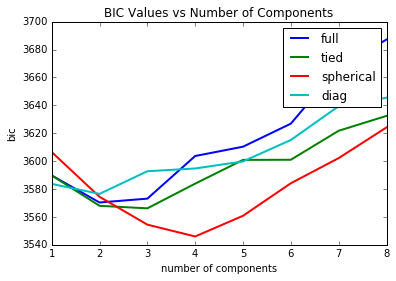

In [38]:
#Adapted from Scikit-Learn examples.
lowest_bic = np.infty
bic = []
n_components_range = range(1, 9)
cv_types = ['full','tied', 'spherical', 'diag'] 
for cv_type in cv_types:
    #print cv_type
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        #print n_components
        gmm = mixture.GMM(n_components=n_components, covariance_type=cv_type)
        gmm.fit(reduced_data)
        bic.append(gmm.bic(reduced_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
print ('best gmm: ', best_gmm)
bic = np.array(bic).reshape((4,8))
bic_df = DataFrame(bic, index=['full','tied', 'spherical', 'diag'], columns=[1,2,3,4,5,6,7,8])
print bic_df
plt.plot(n_components_range, bic_df.loc['full'], linewidth=2.0)
plt.plot(n_components_range, bic_df.loc['tied'], linewidth=2.0)
plt.plot(n_components_range, bic_df.loc['spherical'], linewidth=2.0)
plt.plot(n_components_range, bic_df.loc['diag'], linewidth=2.0)
plt.legend(cv_types)
plt.xlabel('number of components')
plt.ylabel('bic')
plt.title('BIC Values vs Number of Components')

According to above visualization, the best model has 4 components with spherical covariance which has lowest BIC value. The second model could have 3 components with tied covariance.
BIC has some limitations, BIC can not handle where there is a high number of features in the dataset. BIC is only valid where the number of points is much higher than the features [2].

**K-Means Clustering:**
K-means is actually equivalent to the expectation-maximization algorithm with a small, all equal, diagonal covariance matrix. Its main differences from GMM that K-means has a hard assignment where each data point belongs to one cluster. As said in scikit-learn, the algorithm has three steps: 

1.	The first step chooses the initial centroids, with the most basic method being to choose k samples from the dataset X. After initialization, K-means consists of looping between the two other steps. The first step assigns each sample to its nearest centroid. 
2.	The second step creates new centroids by taking the mean value of all of the samples assigned to each previous centroid. 
3.	The difference between the old and the new centroids are computed and the algorithm repeats these last two steps until this value is less than a threshold. In other words, it repeats until the centroids do not move significantly [1].  

K-means seems to have fast and easy calculation to allow someone for quick clustering at the begining and it is faster than GMM. It could be a good choice for large datasets. But not good with large feature sets. K-means has some drawbacks. Choice of initializing the center points will give different cluster results. If the data are not seperated well, it is hard to choose the right cluster. K-means may end up with isotropic clusters for irregular shapes.
To choose the model for wholesale customer data, there is one score that should be taken into account which is Silhouette Coefficient. The coefficients for GMM and K-means are calculated for 4 different number of clusters (2, 3, 4, 5). 

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that we expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, we will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [39]:
# Apply your clustering algorithm of choice to the reduced data 
clusterer = KMeans(n_clusters=5).fit(reduced_data) #, init= 'k-means++',  n_init=20, random_state=0                  
#clusterer = GMM(n_components = 4).fit(reduced_data) #, covariance_type='spherical', params='wmc'

# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# Find the cluster centers
centers = clusterer.cluster_centers_
#centers = clusterer.means_

# Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# Calculate the mean silhouette coefficient for the number of clusters chosen
#score = clusterer.score(reduced_data)
labels = clusterer.labels_
score = metrics.silhouette_score(reduced_data, labels, metric='euclidean')

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
for n_clusters in range_n_clusters:
    clusterers = KMeans(n_clusters=n_clusters, random_state=10)
    #clusterers = GMM(n_components=n_clusters, random_state=10)
    cluster_labels = clusterers.fit_predict(reduced_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)
print len(sample_silhouette_values)

('For n_clusters =', 2, 'The average silhouette_score is :', 0.42628101546910835)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.3903005387988206)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.33293041968141934)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.35220887435264298)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.36458752583307674)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.36487535910995073)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.36437262668066106)
('For n_clusters =', 9, 'The average silhouette_score is :', 0.35908399990804235)
435


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**
**Silhouette_scores for GMM:**

'For n_clusters =', 2, 'The average silhouette_score is :', 0.411

'For n_clusters =', 3, 'The average silhouette_score is :', 0.393

'For n_clusters =', 4, 'The average silhouette_score is :', 0.341

'For n_clusters =', 5, 'The average silhouette_score is :', 0.287

'For n_clusters =', 6, 'The average silhouette_score is :', 0.272

'For n_clusters =', 7, 'The average silhouette_score is :', 0.325

'For n_clusters =', 8, 'The average silhouette_score is :', 0.306

'For n_clusters =', 9, 'The average silhouette_score is :', 0.306

**Silhouette_scores for K-Means:**

'For n_clusters =', 2, 'The average silhouette_score is :', 0.426

'For n_clusters =', 3, 'The average silhouette_score is :', 0.390

'For n_clusters =', 4, 'The average silhouette_score is :', 0.332

'For n_clusters =', 5, 'The average silhouette_score is :', 0.352

'For n_clusters =', 6, 'The average silhouette_score is :', 0.364

'For n_clusters =', 7, 'The average silhouette_score is :', 0.364

'For n_clusters =', 8, 'The average silhouette_score is :', 0.364

'For n_clusters =', 9, 'The average silhouette_score is :', 0.359


For both model the highest silhouette coefficient is for 2 clusters. K-means has higher coefficients for 2, 3, 5, 6, 7 and 8 clusters than GMM has. 

('For n_clusters =', 2, 'The average silhouette_score is :', 0.42628101546910835)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.3903005387988206)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.33293041968141934)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.35220887435264298)


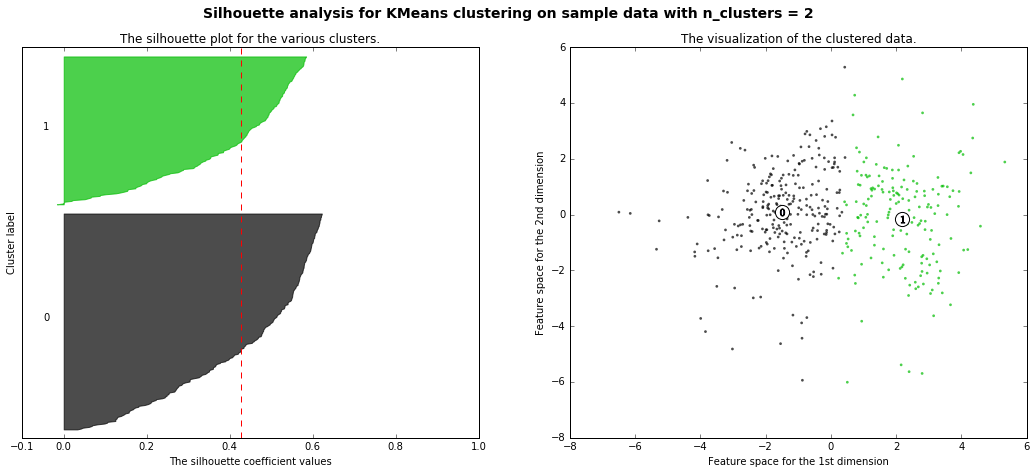

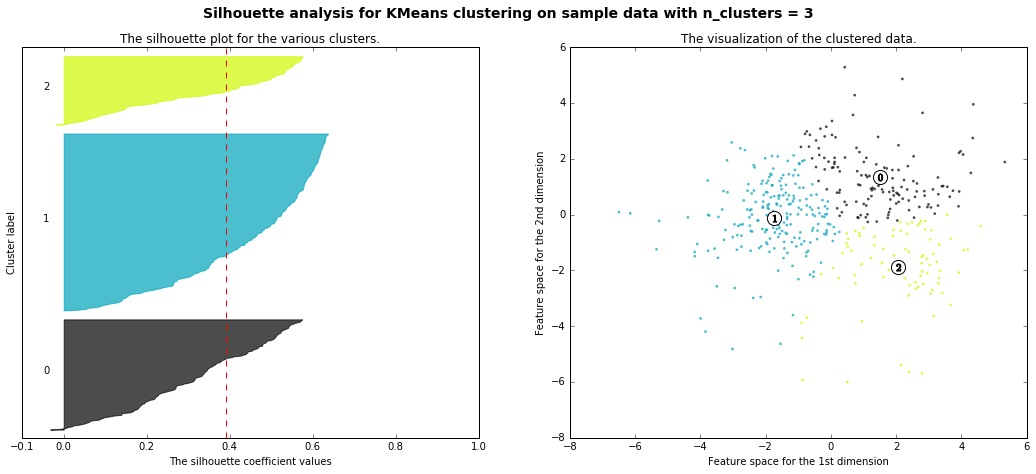

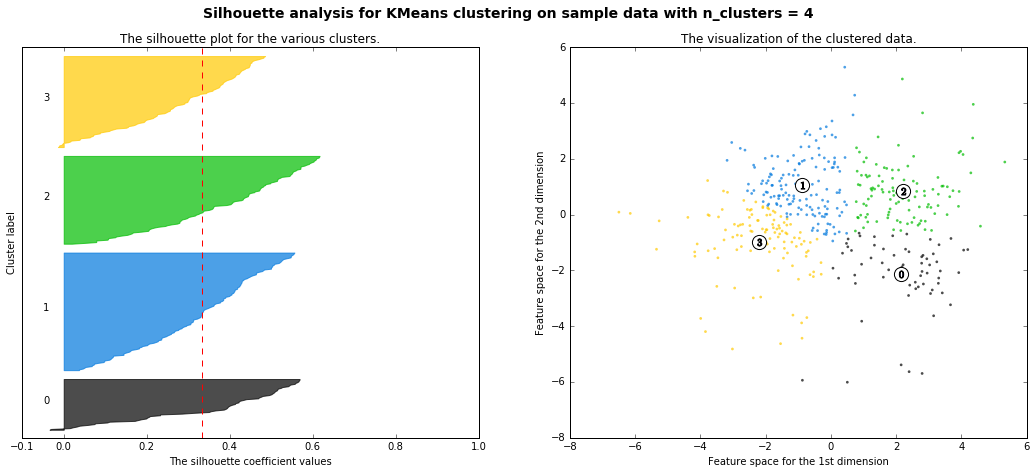

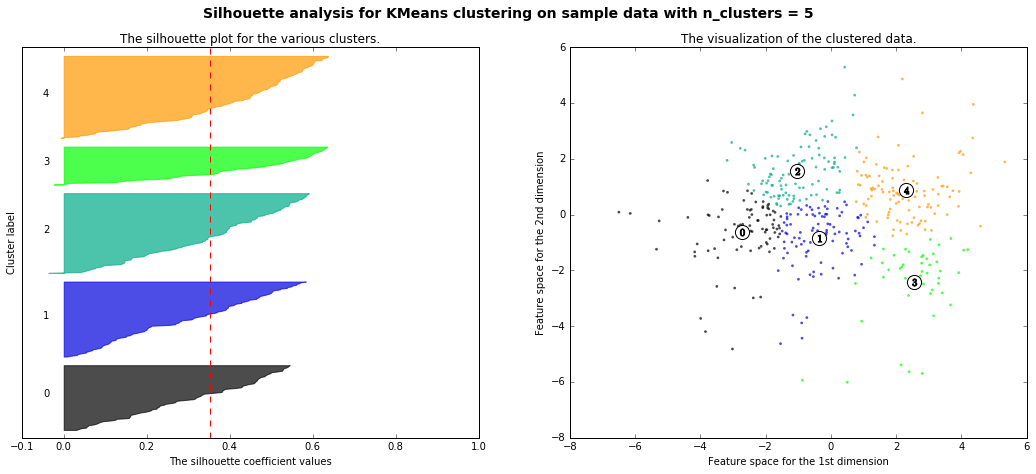

In [40]:
#Silhouette Coefficient analysis for K-means and GMM. There are 2 lines to be changed for GMM analysis.
# clusterer and centers lines!!
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(reduced_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterers = KMeans(n_clusters=n_clusters, random_state=10)
    #clusterers = GMM(n_components=n_clusters, random_state=10) #, covariance_type='spherical'
    cluster_labels = clusterers.fit_predict(reduced_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data.iloc[:, 0], reduced_data.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    center = clusterers.cluster_centers_
    #centers = clusterers.means_ # for GMM
    # Draw white circles at cluster centers
    ax2.scatter(center[:, 0], center[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(center):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st dimension")
    ax2.set_ylabel("Feature space for the 2nd dimension")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold') #Gaussian Mixture Model

Figures above show that K-Means has much less data point with negative Silhouette coefficient value than the GMM has. It seems K-means have better defined clusters. So, I will choose K-means model for customer dataset to define clusters or customer segments. The other question is the number of clusters. 2 cluster has the highest Silhouette coefficient. I think that a wholesale grocery distributer may have more customer segments. We can have an idea by looking at the customer segments of foodservices distributers [3] that has 9 segments which are limited service restaurants, full service restaurants, bars and taverns, retail hosts (supermarkets, c-stores), travel and leisure (recreation, lodging, airlines), business and industry, education, healthcare and other (military, corrections, vending).  I think here are some segments can go in the same segment such as restaurants, bars and taverns, and we can add hotel, cafes, etc. to the list and we should also consider their sizes for example whether they are small restaurant or a big and very busy restaurant. If we choose 2 segments as Silhouette analysis suggests, we may only have general idea about the data in the case of customer dataset. Graphics of K-means with 2 clusters shows that the customers divided by their spending on only feature 1 which represents Detergents_Paper, Grocery and Milk. According to first figure above there are 2 types of customer who purchases feature 1 products much and who does not purchase as much. And this could be restaurants vs. retailers. To my intuition, we should be able to recognize more details about the customers to carry better campaigns. In all the Silhouette analysis, the most of the data are close to 0 which indicates overlapping clusters. This makes choosing the number of clusters difficult. Perhaps in general, we can separate all customers into 2 groups and then try to divide those groups into some other groups. Keeping in mind the result of BIC study which indicated 4 clusters, we can try to recognize the customers with more than 2 clusters. Considering customers cost of feature 2 (Fresh, Frozen, Delicatessen) and with a little bit intuition, I choose 5 clusters to represent customers of wholesale grocery distributer. The 5 clusters of K-means along with the assigned centers and sample data we have been looking at from the beginning can be seen in the following visualization.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

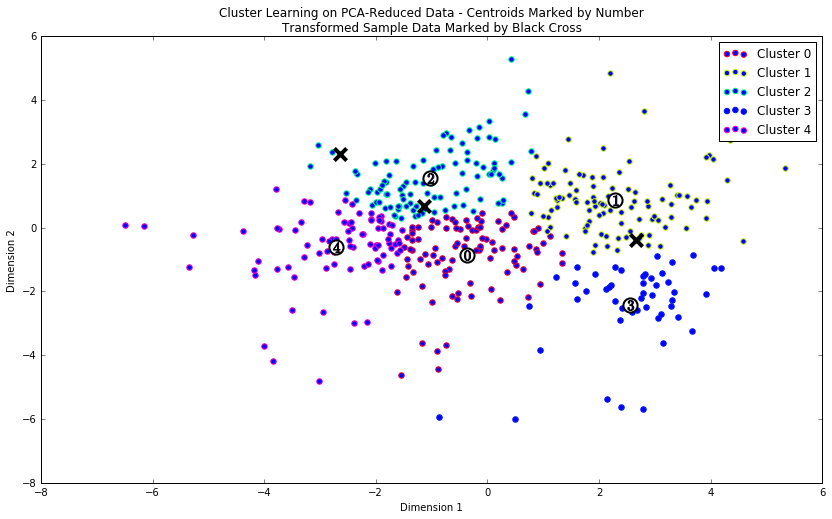

In [41]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, we will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,3811,2541,3792,1059,658,503
Segment 1,7914,9834,13712,1555,5212,1747
Segment 2,22259,2908,3356,3984,441,1497
Segment 3,801,6316,12197,288,5521,360
Segment 4,6660,1027,1374,1815,113,398


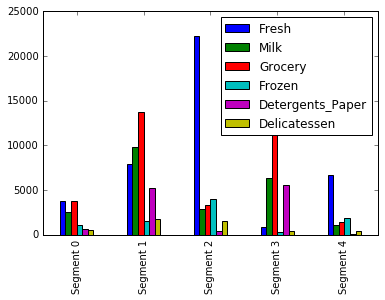

In [42]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)
true_centers.plot(kind = 'bar')

The above Figure (bar visualization of segments) shows that there are segments only differs from each other with their magnitude. Segment 0 & 3 and Segment 2 & 4 are similar with each other. Segment 1 has different characteristics. If we continue with this model we could be able to define customers with different sizes. However, if we would prefer to indentify completely different behavior, then we should choose 3 cluster model. I have checked other possible number of cluster models and seen that other models divide the data like 5 cluster model. Only 3 cluster models choose cluster with different trend in purchasing. At this point I will add 3 cluster model graphics which are as folows.

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8290,1672,2197,2016,242,607
Segment 1,1102,5201,9526,376,3524,384
Segment 2,11484,7892,10346,2122,3123,1889


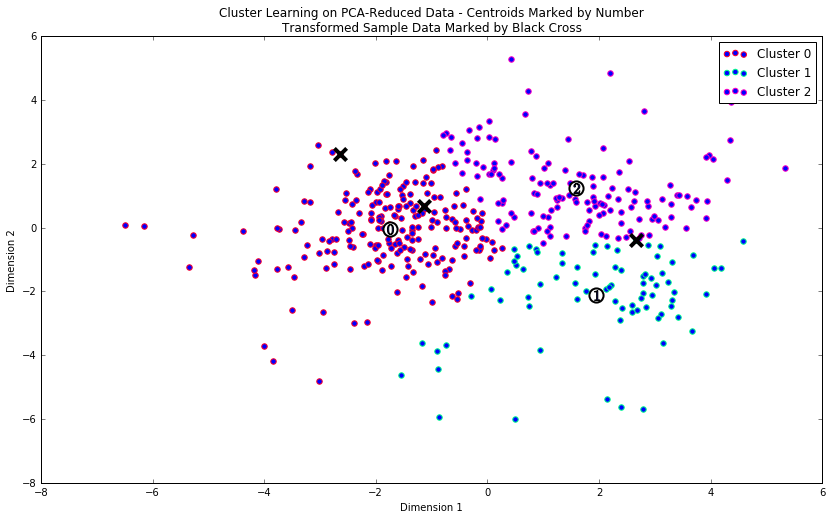

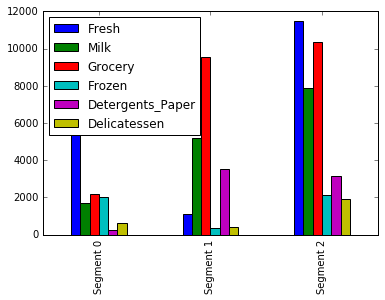

In [43]:
# Apply your clustering algorithm of choice to the reduced data 
clusterer = KMeans(n_clusters=3).fit(reduced_data) 
# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# Find the cluster centers
centers = clusterer.cluster_centers_

# Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

rs.cluster_results(reduced_data, preds, centers, pca_samples)
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)
true_centers.plot(kind = 'bar')

### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**

•	**Segment 1:** Most of the spendings are more than mean value or close and this segment has the highest total cost. This could be a big supermarket, retailer, etc who buys all kind of thing in a big amount.
•	**Segment 0:** All of the spendings are less than mean value and has the lowest total cost of all products. Their spendings mostly belongs to Fresh, Frozen, Delicatessen group. This could be restaurant, cafe, tavern, grocery store 
•	**Segment 2:** This could belong to customers who purchases much from the group of Grocery, Milk and Detergents_Paper and very low from the group of Fresh, Frozen, Delicatessen. This segment could belong to some kind of retailers, warehouses or convenince stores.


Since most of the data points very close to each other, it is not possible to separate them exactly. For example, in the grocery store segment, there still could be a restaurant or in the convenience store segment, there may be a supermarket. 



### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*


In [44]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


**Answer:** The data with indices 50 and 401 are in the segment 0 (restaurant, grocery store) , and the data with indices 301 is in the segment 1 (supermarket). The predictions made so far is consistent with segment predictions. 

## Conclusion

### Question 10
*Companies often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services. If the wholesale distributor wanted to change its delivery service from 5 days a week to 3 days a week, how would you use the structure of the data to help them decide on a group of customers to test?*  
**Hint:** Would such a change in the delivery service affect all customers equally? How could the distributor identify who it affects the most?

**Answer:** A/B testing is a method of comparing (in customer segmentation case) old service and new service against each other in terms of customer’s response. As the name implies, two versions (for example old service and new service) could be compared, which are identical except for one variation that might affect a customer’s behavior. When more than two variables are used, that application can be called bucket testing or split-run testing [4]. And it is important to note that if segmented results are expected from the A/B test, the test should be properly designed at the outset to be evenly distributed across key customer attributes. In our problem, the key customer attributes could be Dimention 1. I will offer 3 strategies for A/B test at this point.
1.	Since 5 different customer segment have been defined, the half of customers can be chosen from half of each segment. The distributer already experienced that smaller family run shops have hard times adapting to change. So I expect dissatisfied response from the segment 0 and 4 whose total cost are low which indicates smaller shops. Perhaps segment 0 and 4 customers can be treated a little bit different way, instead of reducing the delivery time from 5 days to 3 days a week, they may try 4 days a week.
2.	I think for A/B testing, there could be other strategies such is separating the customers into two groups. For this, we can consider the 2 cluster model of K-means which was separating the customers according to one variation in their cost. In Figure 10, there are two groups and variation is Dimension 1. If the wholesale distributer wanted to change its delivery service from 5 days to 3 days a week, I would suggest the 2 cluster model and separate the customers into two groups according to amount of cost of Dimention 1 calculated by PCA analysis which corresponds to Detergents_Paper, Grocery, Milk features. Then they can apply the change to the half of the one group (for example cluster 0 in Figure with 2 clusters), and also to the half of the other group (cluster 1 in Figure with 2 cluster). Again cluster 1 has lower total cost and they may be unhappy with the change. In this strategy the number of customer belong to segment 1 is higher than the customers belong to segment 0&4 in first strategy. When using the second strategy they may have general idea.
3.	This strategy mostly is similar with the 2nd strategy. Again the half of the customers could be chosen from 3 clusters. The distributer can implement the change in these group and this time the distributer should be careful for customers from Segment 0.


### Question 11
*Assume the wholesale distributor wanted to predict some other feature for each customer based on the purchasing information available. How could the wholesale distributor use the structure of the data to assist a supervised learning analysis?*

**Answer:** We can assign label to each data point with using labels_ attribute of K-means clustering model. Depending on the wholesale distributer choice of A/B test strategy, they would apply label assignment attribute. In 5 cluster model, we could have 5 different label category and in 2 cluster model, we could have 2 label category. Those labels can be treated as target (y column) for a Classifier Learner from any one of supervised learning techniques such as Decision Tree Classifier, Stochastic Gradient Descent Classifier, Support Vector Machines Classifier, Nearest Neighbor Classifier, etc. In other words, when the wholesale grocery distributor has new customer with some purchase for Fresh, Milk, they can estimate how much the new customer will spend for other products. With the data structure they already have and using the new labels as a predictor, they can make predictions regarding future customers spendings.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier on to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

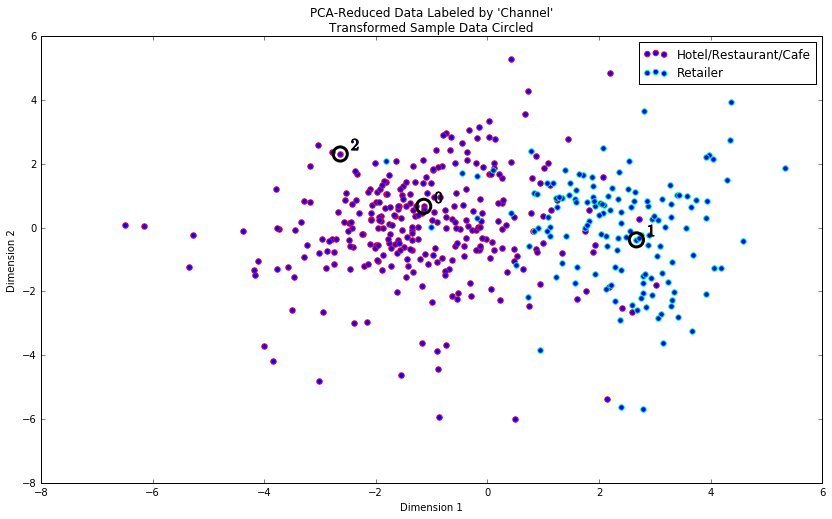

In [45]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:** The above visualising shows very interesting results and yields actually very consistent results with the 2 cluster model. The 2 types of customers ‘HoReCa’ and ‘Retailer’ are separated with each other according to their Dimention 1 properties. Eventhough some points seem to overlap, overall distribution actually can be separated into 2 parts which could respresent the 2 customer segments with a low level of purity. This classification also show some consistency with previous definition of  5 customer segments. Because the restaurants fall into same segments with the labeled distribution, and big retailers fall into other segment again consistent with the previous definition. The classification shows consistency with 3 cluster model as well.